---
# Modelling hippocampal neurons of animals navigating in VR with recurrent neural networks
### Marco P. Abrate, Daniel Liu
---

##### Outline
Rat simulation:
- Motion model (RatInABox)
- Environment design (Blender)
- Simulated rat vision (ratvision)

Vision autoencoder

Hippocampus model (RNN):
- RNN definition
- Data loading
- Training

Hidden state representations analysis:
- Rate maps
- Polar maps
- Quantitive metrics
- Comparison with real data

---
## **Part 3: Modelling the hippocampus with an RNN**
In this notebook, we will write code to define the Recurrent Neural Network (**RNN**), which will serve as the model of the hippocampus.

RNNs are models designed to process sequential data by retaining memory over time. Specifically in this tutorial, we train an RNN to perform a **next-step prediction task** on a self-supervised task.

What is next-step prediction and why?



Prerequisites:

* Completed Notebook 1

Before starting this notebook, make sure you have:
- trajectory data from part 1, including speed and rotational speed
- vision data (frames) from part 1
- embedded vision data from the Vision Autoencoder we trained in part 2


### **0. Install and import dependencies**

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
    
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

### **1. Load trajectory and vision embeddings**

In [2]:
# our trajectories are at 10 FPS, we want to subsample them to 1 FPS
STRIDE = 10

In [3]:
d = './data/adult'
trial_paths = sorted([p for p in Path(d).iterdir() if 'exp' in p.name])
trial_paths

[PosixPath('data/adult/exp_dim0.635_fps10_s720_seed01'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed02'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed03'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed04'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed05'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed06'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed07'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed08'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed09'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed10'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed11'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed12'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed13'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed14'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed15'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed16'),
 PosixPath('data/adult/exp_dim0.635_fps10_s720_seed17'),
 PosixPath('data/adult/exp_dim0

In [4]:
def create_multiple_subsampling(data, stride, is_velocity=False):
    new_length = data.shape[0]//stride if not is_velocity else data.shape[0]//stride-1
    data_multisubs = np.zeros(
        (stride, new_length, data.shape[1]),
        dtype=np.float32
    )
    for start_idx in range(stride):
        if is_velocity:
            if start_idx < stride-1:
                data_multisubs[start_idx] = data[start_idx+1:start_idx-stride+1].reshape(
                    new_length, stride, -1
                ).sum(axis=1)
            else:
                data_multisubs[start_idx] = data[start_idx+1:].reshape(
                    new_length, stride, -1
                ).sum(axis=1)
        else:
            data_multisubs[start_idx] = data[start_idx::stride]
    return data_multisubs

In [5]:
train_embeddings = []
train_vel, train_rotvel, train_pos, train_hds = [], [], [], []

for idx in range(20):
    tp = trial_paths[idx]
    train_embeddings.append(
        create_multiple_subsampling(np.load(tp / 'vision_embeddings.npy'), stride=STRIDE)
    )
    train_vel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'velocities.npy'), stride=STRIDE, is_velocity=True
        )
    )
    train_rotvel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'rot_velocities.npy')[..., None],
            stride=STRIDE, is_velocity=True
        )
    )
    train_pos.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'positions.npy'), stride=STRIDE)
    )
    train_hds.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'thetas.npy')[..., None], stride=STRIDE)
    )

train_embeddings = np.concatenate(train_embeddings, axis=0)
train_vel = np.concatenate(train_vel, axis=0)
train_rotvel = np.concatenate(train_rotvel, axis=0)
train_pos = np.concatenate(train_pos, axis=0)
train_hds = np.concatenate(train_hds, axis=0)


In [6]:
test_embeddings = []
test_vel, test_rotvel, test_pos, test_hds = [], [], [], []

for idx in range(20, 23):
    tp = trial_paths[idx]
    test_embeddings.append(
        create_multiple_subsampling(np.load(tp / 'vision_embeddings.npy'), stride=STRIDE)
    )
    test_vel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'velocities.npy'), stride=STRIDE, is_velocity=True
        )
    )
    test_rotvel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'rot_velocities.npy')[..., None],
            stride=STRIDE, is_velocity=True
        )
    )
    test_pos.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'positions.npy'), stride=STRIDE)
    )
    test_hds.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'thetas.npy')[..., None], stride=STRIDE)
    )

test_embeddings = np.concatenate(test_embeddings, axis=0)
test_vel = np.concatenate(test_vel, axis=0)
test_rotvel = np.concatenate(test_rotvel, axis=0)
test_pos = np.concatenate(test_pos, axis=0)
test_hds = np.concatenate(test_hds, axis=0)


In [7]:
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Train velocities shape: {train_vel.shape}")
print(f"Train rotational velocities shape: {train_rotvel.shape}")
print(f"Train positions shape: {train_pos.shape}")
print(f"Train head directions shape: {train_hds.shape}")
print()
print(f"Test embeddings shape: {test_embeddings.shape}")
print(f"Test velocities shape: {test_vel.shape}")
print(f"Test rotational velocities shape: {test_rotvel.shape}")
print(f"Test positions shape: {test_pos.shape}")
print(f"Test head directions shape: {test_hds.shape}")

Train embeddings shape: (200, 720, 100)
Train velocities shape: (200, 719, 2)
Train rotational velocities shape: (200, 719, 1)
Train positions shape: (200, 720, 2)
Train head directions shape: (200, 720, 1)

Test embeddings shape: (30, 720, 100)
Test velocities shape: (30, 719, 2)
Test rotational velocities shape: (30, 719, 1)
Test positions shape: (30, 720, 2)
Test head directions shape: (30, 720, 1)


### **2. Define dataloader**

To allow our RNN to perform a next-step prediction task, we can use a **Dataset** and **DataLoader** to make our life easier. The **Dataset** prepares sensory embeddings as well as motion signals to batches of paired inputs and labels; the **DataLoader** sequentially generates these batches during training and testing.

The Dataset and Dataloader classes will inherit PyTorch's built-in ```torch.utils.data.Dataset``` and ```torch.utils.data.DataLoader``` classes.

In [8]:
class SensoryDataset(torch.utils.data.Dataset):
    def __init__(self, embs, vels, rot_vels, pos, hds, tsteps=9):
        '''
        The initialisation function for the SensoryDataset class.
        At initialisation, all embeddings are converted to tensors.
        Args:
            embs: The visual embeddings of shape (N, T, D)
            vels: The speed signals of shape (N, T-1, 1)
            rot_vels: The rotational velocities of shape (N, T-1, 1)
            pos: The positions of shape (N, T, 2)
            hds: The headings of shape (N, T, 1)
            tsteps: The number of time steps for each batch.
                By default, this is set to 9 i.e. we use the sensory input from steps 1 to 9          
        '''
        self.embs = torch.from_numpy(embs)
        self.vels = torch.from_numpy(vels)
        self.rot_vels = torch.from_numpy(rot_vels)
        self.pos = torch.from_numpy(pos)
        self.hds = torch.from_numpy(hds)
        
        self.tsteps = tsteps
    
    def __len__(self):
        # COMPLETE THE CODE HERE: how many samples are in the dataset?
        return self.embs.shape[1] // self.tsteps - 1
    
    def __getitem__(self, idx):
        '''
        This function returns a batch of sensory inputs and the corresponding future sensory inputs.
        Args:
            idx: The index of the sample to return. idx will be automatically generated by the DataLoader.
        Returns:
        
        '''
        vels, rot_vels, pos, hds, embs_labels = [], [], [], [], []

        start_idx, end_idx = idx*self.tsteps, (idx + 1)*self.tsteps

        embs = self.embs[:, start_idx:end_idx]

        vels = self.vels[:, start_idx:end_idx]
        rot_vels = self.rot_vels[:, start_idx:end_idx]
        pos = self.pos[:, start_idx:end_idx]
        hds = self.hds[:, start_idx:end_idx]

        embs_labels = self.embs[:, start_idx+1 : end_idx+1]
        
        return embs, vels, rot_vels, pos, hds, embs_labels


In [9]:
# very important: we do not shuffle the datasets because
# hidden states are dependent on the previous batch
train_dataloader = torch.utils.data.DataLoader(
    SensoryDataset(
        train_embeddings, train_vel, train_rotvel, train_pos, train_hds
    ), shuffle=False
)

test_dataloader = torch.utils.data.DataLoader(
    SensoryDataset(
        test_embeddings, test_vel, test_rotvel, test_pos, test_hds
    ), shuffle=False
)

In [10]:
for b in train_dataloader:
    embs, vels, rot_vels, pos, hds, embs_labels = b
    print('Shape of the batch (1, BATCH_SIZE, TIMESTEPS, N_FEATURES)')
    print()
    print(f'Embeddings:\t\t{embs.shape}')
    print(f'Velocities:\t\t{vels.shape}')
    print(f'Rot. velocities:\t{rot_vels.shape}')
    print(f'Positions:\t\t{pos.shape}')
    print(f'Head directions:\t{hds.shape}')
    print(f'Embeddings labels:\t{embs_labels.shape}')
    break


Shape of the batch (1, BATCH_SIZE, TIMESTEPS, N_FEATURES)

Embeddings:		torch.Size([1, 200, 9, 100])
Velocities:		torch.Size([1, 200, 9, 2])
Rot. velocities:	torch.Size([1, 200, 9, 1])
Positions:		torch.Size([1, 200, 9, 2])
Head directions:	torch.Size([1, 200, 9, 1])
Embeddings labels:	torch.Size([1, 200, 9, 100])


### **3. Define the RNN**

Let's define the RNN that will serve as out hippocampus. This network will use a customized ```RNNModule``` class, which you can find in `rnn/rnn_module.py`, that applies a Sigmoid activation function to the hidden state. The hidden states are projected to predict the next sensory state via a linear layer.

The output of the Sigmoid sits between 0 and 1, which can be interpreted as the (scaled) firing rate (or simply activity) of each neuron.

In [11]:
class RNNCell(torch.nn.Module):
    def __init__(self, n_inputs, n_hidden, input_bias, hidden_bias):
        super(RNNCell, self).__init__()

        self.in2hidden = torch.nn.Linear(n_inputs, n_hidden, bias=input_bias)
        self.hidden2hidden = torch.nn.Linear(n_hidden, n_hidden, bias=hidden_bias)

        self.activation_fn = torch.nn.Sigmoid()

    def forward(self, x, hidden):
        igates = self.in2hidden(x)
        hgates = self.hidden2hidden(hidden)
        return self.activation_fn(igates + hgates)


class RNNModule(torch.nn.Module):
    def __init__(
        self, device, n_inputs, n_hidden,
        input_bias, hidden_bias
    ):
        super(RNNModule, self).__init__()

        self.rnn_cell = RNNCell(n_inputs, n_hidden, input_bias, hidden_bias)
        self.n_hidden = n_hidden

        self.device = device

    def forward(self, x, hidden=None):
        # x: [BATCH SIZE, TIME, N_FEATURES]
        # hidden: [BATCH SIZE, N_HIDDEN]
        
        output = torch.zeros(x.shape[0], x.shape[1], self.n_hidden).to(self.device)

        if hidden is None:
            h_out = torch.zeros(x.shape[0], self.n_hidden) # initialize hidden state
            h_out = h_out.to(self.device)
        else:
            h_out = hidden

        window_size = x.shape[1]

        # loop over time
        for t in range(window_size):
            x_t = x[:,t,...]
            h_out = self.rnn_cell(x_t, h_out)
            output[:,t,...] = h_out

        # return all outputs, and the last hidden state
        return output, h_out
    

In [12]:
class PredictiveRNN(torch.nn.Module):
    def __init__(self,
        device, n_inputs, n_hidden, n_outputs, bias=False
    ):
        super().__init__()

        self.rnn = RNNModule(
            device, n_inputs, n_hidden,
            input_bias=bias, hidden_bias=bias
        )

        self.linear_layer = torch.nn.Linear(n_hidden, n_outputs, bias=bias)

    def inputs2hidden(self, inputs, hidden):
        """ Encodes the input tensor into a latent representation.

        Args:
            x: [BATCH SIZE, TIME, CHANNELS, HEIGHT, WIDTH]
        """
        
        if hidden is not None:
            return self.rnn(inputs, hidden[None, ...])[0]
        else:
            return self.rnn(inputs)[0]

    def hidden2outputs(self, hidden):
        return self.linear_layer(hidden)
    
    def forward(self, inputs, hidden=None):
        hidden_new = self.inputs2hidden(inputs, hidden)

        output = self.hidden2outputs(hidden_new)

        return output, hidden_new[:,-1,:]


Note that the input dimension would be both the visual embedding dimension and the motion signal, while the output dimension would be only the visual embedding dimension.

In [13]:
visual_embedding_dim = train_embeddings.shape[-1]
motion_signal_dim = train_vel.shape[-1] + train_rotvel.shape[-1]

rnn = PredictiveRNN(
    DEVICE,
    n_inputs=visual_embedding_dim + motion_signal_dim,
    n_hidden=500,
    n_outputs=visual_embedding_dim
).to(DEVICE)

### **4. Define training objects**

Training the RNN is similar to training the autoencoder, except that we need to **pass the hidden state from one batch to the next**, it's important to note that batches are now sequential rather than independent.

In [14]:
def train_epoch(
    rnn,
    dataloader,
    loss_fn, optimizer
):
    '''
    This function trains the RNN for one epoch. 
    We will default to only predcting the next step sensory input,
    i.e. n_future_pred = 1.
    '''
    rnn.train()
    
    batch_losses = []
    hidden_state = None # Initialize hidden state to zeros

    for batch in dataloader:
        optimizer.zero_grad()

        embs, vels, rot_vels, _, _, embs_labels = batch
        
        # COMPLETE THE CODE HERE:
        inputs = torch.cat((
            embs.squeeze(dim=0).to(DEVICE),
            vels.squeeze(dim=0).to(DEVICE),
            rot_vels.squeeze(dim=0).to(DEVICE)
        ), dim=-1)

        outputs, hidden_new = rnn(inputs, hidden_state)

        embs_labels = embs_labels.squeeze(dim=0).to(DEVICE)

        # compute the loss and its gradients
        loss = loss_fn(outputs, embs_labels)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(rnn.parameters(), 1.0)
        optimizer.step()
        
        batch_losses.append(loss.detach().item())

        # Assign new RNN hidden state to variable.
        # Detach it to prevent backpropagation
        # through the entire history
        hidden_state = hidden_new.detach()

    return batch_losses 

A paired test function has been provided for convenience. This function additionally saves the hidden state at each step. This is needed for computing the rate maps in the later parts of this tutorial. It is structured like this:

```python
def test_rnn_epoch(rnn, dataloader, loss_fn, stepwise=True):
    ...
    return test_dict    
```

Where, ```test_dict``` is a dictionary containing the following keys:
* ```batch_losses```;
* ```h_ts```, the hidden state at each time step;
* ```pos```, the (x, y) position of the agent at each time step;
* ```hds``, the (dx, dy) direction of the agent at each time step as a unit circle;
* ```thetas```, the head bearing of the agent at each time step.

This function will be imported below.

In [15]:
from utils import evaluate_rnn

### **5. Train RNN on self-supervised predictive task**

We will define some parameters and train the RNN.

In [ ]:
n_epochs = 1_000
learning_rate = 1e-4

loss_fn = torch.nn.L1Loss()

optimizer = torch.optim.RMSprop(rnn.parameters(), lr=learning_rate)

# optional: use a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5,
    patience=50, threshold=1e-3
)


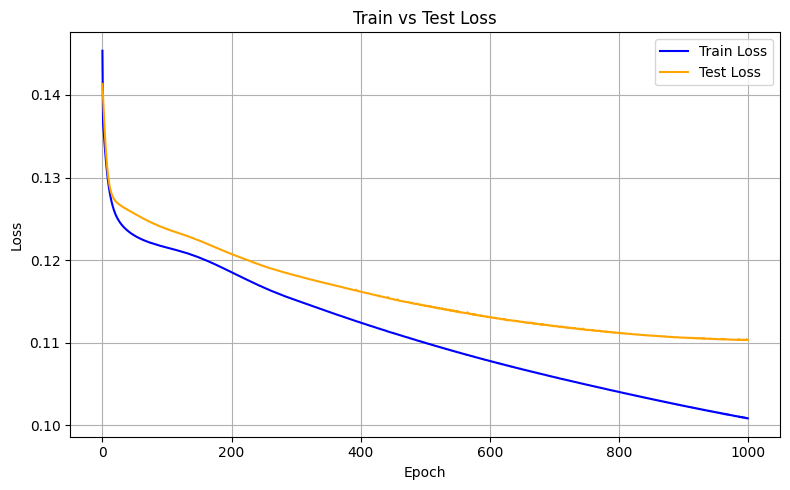

In [17]:
from IPython.display import clear_output

train_means, test_means = [], []
train_stds, test_stds = [], []
epochs = []

# Main training loop
for epoch in range(n_epochs):
    # COMPLETE THE CODE HERE: train the RNN for one epoch, then test it
    train_losses = None
    test_dict = None
    
    train_losses = train_epoch(rnn, train_dataloader, loss_fn, optimizer)
    d = evaluate_rnn(DEVICE, rnn, test_dataloader, loss_fn, for_ratemaps=False)
    
    
    train_mean = np.mean(train_losses)

    test_losses = d['batch_losses']
    test_mean = np.mean(test_losses)

    scheduler.step(test_mean)

    train_means.append(train_mean)
    test_means.append(test_mean)

    # Clear previous plot output
    clear_output(wait=True)
    
    # Create new plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(epoch+1), train_means, label='Train Loss', color='blue')
    plt.plot(range(epoch+1), test_means, label='Test Loss', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Test Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
torch.save(rnn.state_dict(), 'rnn.pth')

# load as
# rnn = PredictiveRNN(
#     DEVICE,
#     n_inputs=visual_embedding_dim + motion_signal_dim,
#     n_hidden=500,
#     n_outputs=visual_embedding_dim
# )
# rnn.load_state_dict(torch.load('rnn.pth', weights_only=True)).to(DEVICE)

### **What have we achieved in this tutorial?**

We trained a recurrent neural network to perform the next-step prediction task.

In the next tutorial, we will look into how to extract realistic place cell rate maps from this RNN.